# System preparation

## Import libraries

In [ ]:
#pip install scikit-plot

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Classification
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score , roc_auc_score

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve


# Classification algorithms
import lightgbm as lgb
#from xgboost import XGBClassifier as xgb
import xgboost as xgb

from sklearn import ensemble

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier


# Others
import warnings
from functools import reduce
from pathlib import Path
import os


#Predefined functions
from functions.evaluation_models import models_evaluation



In [2]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# 2. DIAGNOSTICS

Predictive maintenance can be formulated in one of the two ways:


*   Classification approach - predicts whether there is a possibility of failure in next n-steps.

*   Regression approach - predicts how much time is left before the next failure. We call this Remaining Useful Life (RUL).



The former approach only provides a boolean answer, but can provide greater accuracy with less data. The latter needs more data although it provides more information  about when the failure will happen. 

In the diagnostics section we will explore the classification approach

## What **predictive manintenance model** to apply?






As we saw before, the state of the art includes 5 different approaches. For this it would only be studied the case in which vibrations and motor current are considered. Fluid analysis and ultra-sound test will be implemented in further stage.
1. Using both Vibration Analysis and Motor Current Analysis
2. Using Fluid Analysis *(Yet under development)*
3. Using Ultra-Sound Test *(Yet under development)*


## 1. Predictive maintenance with vibrations motor temperature and motor current

To move from periodic compressor maintenance to predictive maintenance, the four parameters that will be monitored are motor vibration, motor current, rpm and outlet pressure.

These parameters are good indicators of compressor health, are simple to start with, and can be instrumented without much effort or cost—and without taking the machine apart.

There is need of **vibration** sensors (motor and windings) with a 4-20 mA output. These sensors are widely available, inexpensive and could be mounted on the motor and other areas. We would need 12-30 VDC to power the loop, and the 4-20 mA signal would be wired to a SNAP-AIMA module.

Next, the motor’s **three-phase current** can be meassured by using three split-core current transformers installed at the compressor disconnect switch. The motor is rated at about 90 A, so we'd select appropriate current transformers (CTs) with an adequate inner diameter to accommodate the feed wire. Many CTs have a standard 5 A secondary, so we would wire these three signals to two SNAP-AIARMS modules.


<p align="center">
  <img width="460" height="500" src="https://blog.opto22.com/hs-fs/hubfs/Blog_predictiveMaintenance.jpg?width=352&name=Blog_predictiveMaintenance.jpg">
</p>


# Classification


The diagnostics step deals with fault detection and failure mode identification based on the extracted feature values.

Fault diagnostics are usually formulated as a classification problem. As a result, popular classification methods, such as k-nearest neighbors, support vector machines, decision trees, random forest, are widely adopted to predict the system health state labels given the observed feature values. A simple illustration of applying the decision tree model to classify the system failure mode is given below.



<p align="center">
  <img width="460" height="500" src="https://miro.medium.com/max/1284/1*df_goQhP8XYQRTVNxygCLQ.png">
</p>

### Load data



Read the csv with the feature engineering applied before to the raw data.

In [3]:
compressors_all_data = pd.read_csv("../data/compressors_all_data_best_features_2days.csv", error_bad_lines=False, index_col=0)

In [4]:
#Make sure the datetime format is correct
compressors_all_data["datetime"] = pd.to_datetime(compressors_all_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [5]:
compressors_all_data.head()

,compressorID,datetime,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,...,s-8760,c-8760,comp1_fail,comp2_fail,comp3_fail,comp4_fail,rul_comp1,rul_comp2,rul_comp3,rul_comp4
0,1,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,NaN,NaN,NaN,...,0.000000,1.000000,0.0,0.0,0.0,0.0,63.875,108.875,NaN,3.875
1,1,2015-01-01 12:00:00,2,164.192565,403.949857,105.687417,34.255891,NaN,NaN,NaN,...,0.002152,0.999998,0.0,0.0,0.0,0.0,63.750,108.750,NaN,3.750
2,1,2015-01-01 15:00:00,3,168.134445,435.781707,107.793709,41.239405,NaN,NaN,NaN,...,0.004304,0.999991,0.0,0.0,0.0,0.0,63.625,108.625,NaN,3.625
3,1,2015-01-01 18:00:00,4,165.514453,430.472823,101.703289,40.373739,NaN,NaN,NaN,...,0.006455,0.999979,0.0,0.0,0.0,0.0,63.500,108.500,NaN,3.500
4,1,2015-01-01 21:00:00,5,168.809347,437.111120,90.911060,41.738542,NaN,NaN,NaN,...,0.008607,0.999963,0.0,0.0,0.0,0.0,63.375,108.375,NaN,3.375


Create lists with the names of the columns for different data:
- Sensors: telemetry information
- Errors: compressor errors and counts
- Maintenance: time since last maintenance
- Model
- Compressor information: Age
- Failures: failures in the different components

## Feature selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [6]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]
cols_rul = [col for col in compressors_all_data.columns if 'rul' in col]

In [7]:
predictors = list(compressors_all_data.columns)
predictors = [ele for ele in predictors if ele not in (cols_rul + cols_failures_dum + ['datetime']) ]

In [8]:
target = cols_failures_dum 

In [9]:
X = compressors_all_data[(predictors+target)+ ['datetime']].dropna()
y = compressors_all_data[(predictors+target)+ ['datetime']].dropna()

In [10]:
X = X[predictors+ ['datetime']]
y= y[target+ ['datetime']]

## Model split: Training, Validation and Testing

When working with time series as in this thesis, partitioning in training, validation, and testing must be done carefully to avoid overestimating the performance of the models. 

Predictive models do not have advanced knowledge of future time trends - in practice, such trends are likely to exist and have an adverse impact on model performance. To get an accurate assessment of the performance of a predictive model, it is recommended to perform training on older records and validation / testing using the newer records.

For both reasons, a time-dependent splitting strategy is an excellent choice for predictive maintenance models. The division is done by choosing a point in time according to the desired size of the training and test sets: all the records before the time point are used to train the model, and all the remaining records are used for testing.

In [11]:
# We establish the times corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [12]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [13]:
# Typically 20-30% of the data is used.
X_train = X.loc[X["datetime"] < last_train_date]
y_train = y.loc[y["datetime"] < last_train_date]

X_test = X.loc[X["datetime"] > first_test_date]
y_test = y.loc[y["datetime"] > first_test_date]

print(f"{X_train.shape[0]} registers for trainning")
print(f"{X_test.shape[0]} registers for testing")
print(f"{X_test.shape[0] / X_train.shape[0] * 100:0.1f}% of the total data is used for testing")

216700 registers for trainning
73900 registers for testing
34.1% of the total data is used for testing


Check how many failures we have in the train and test

In [14]:
fails_train = y_train[y_train["comp1_fail"] != 0].shape[0]
no_fails_train = y_train[y_train["comp1_fail"] == 0].shape[0]
fails_test = y_test[y_test["comp1_fail"] != 0].shape[0]
no_fails_test = y_test[y_test["comp1_fail"] == 0].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% of the total cases are failures in the train dataset")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the total cases are failures in the test dataset")

1.1% of the total cases are failures in the train dataset
0.9% of the total cases are failures in the test dataset


We see it's crearly an unbalanced problem. For class unbalance problems Get more data. Minor sample of the majority class. SMOTE (Synthetic Minority Over-sampling Technique). Assign weights to minority class.

## Drop Datetime

In [15]:
X.drop('datetime', axis=1,inplace=True)
y.drop('datetime', axis=1,inplace=True)

X_train.drop('datetime',axis=1,inplace=True)
y_train.drop('datetime',axis=1,inplace=True)

X_test.drop('datetime',axis=1,inplace=True)
y_test.drop('datetime',axis=1,inplace=True)

## Comparison between algorithms

Instantiate the machine learning classifiers

In [16]:
# Listing models

models = []
models.append(('LOGR', LogisticRegression()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier(objective='binary:logistic',eval_metric='auc')))
models.append(('LGBMC', LGBMClassifier()))


#### ROC curves

AUC-ROC curve is a performance metric for binary classification problem at different thresholds. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

In [17]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'compressor', 'time', 'fpr','tpr','auc'])

# Train the models and record the results
for name, model in models:


        for compr in y:

          # set start time
          print(f'Executing {name} for {compr}...')

          start_time = time()

          classifier = model.fit(X_train, y_train[compr])
          yproba = classifier.predict_proba(X_test)[::,1]
          
          fpr, tpr, _ = roc_curve(y_test[compr],  yproba)
          auc = roc_auc_score(y_test[compr], yproba)
          
          # set end time: execution time
          exec_time = time() - start_time

          result_table = result_table.append({'classifiers':classifier.__class__.__name__,
                                              'compressor': compr,
                                              'time':exec_time,
                                              'fpr':fpr, 
                                              'tpr':tpr, 
                                              'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

Executing LOGR for comp1_fail...
Executing LOGR for comp2_fail...
Executing LOGR for comp3_fail...
Executing LOGR for comp4_fail...
Executing TREE for comp1_fail...
Executing TREE for comp2_fail...
Executing TREE for comp3_fail...
Executing TREE for comp4_fail...
Executing RFC for comp1_fail...
Executing RFC for comp2_fail...
Executing RFC for comp3_fail...
Executing RFC for comp4_fail...
Executing GNB for comp1_fail...
Executing GNB for comp2_fail...
Executing GNB for comp3_fail...
Executing GNB for comp4_fail...
Executing LDA for comp1_fail...
Executing LDA for comp2_fail...
Executing LDA for comp3_fail...
Executing LDA for comp4_fail...
Executing KNN for comp1_fail...
Executing KNN for comp2_fail...
Executing KNN for comp3_fail...
Executing KNN for comp4_fail...
Executing XGB for comp1_fail...
Executing XGB for comp2_fail...
Executing XGB for comp3_fail...
Executing XGB for comp4_fail...
Executing LGBMC for comp1_fail...
Executing LGBMC for comp2_fail...
Executing LGBMC for comp3_fa

Source : https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

We will now plot the ROC Curves for the models we are comparing

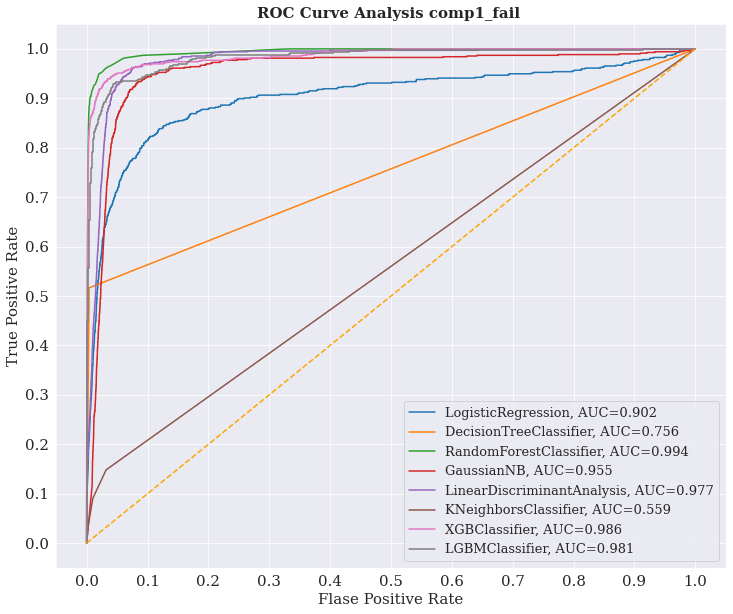

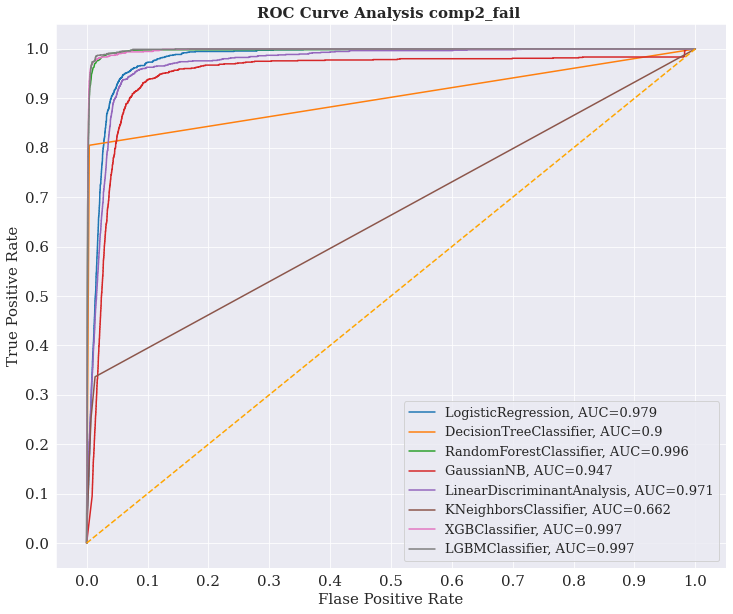

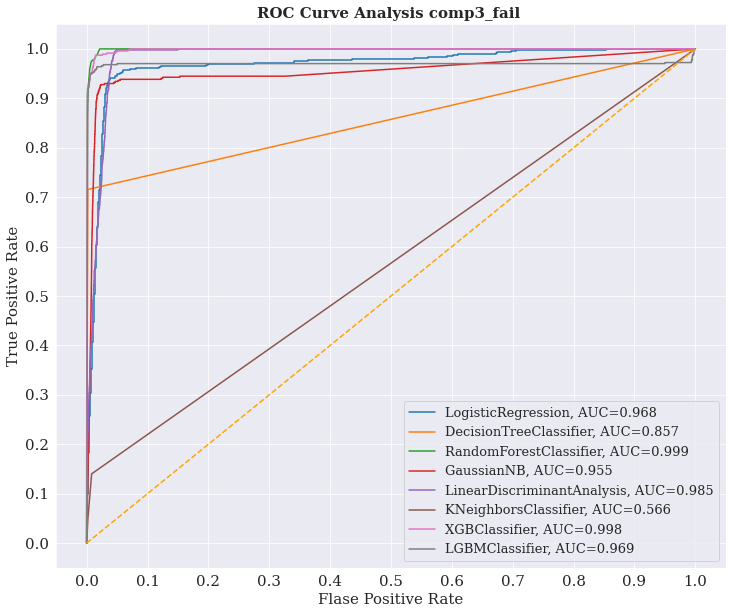

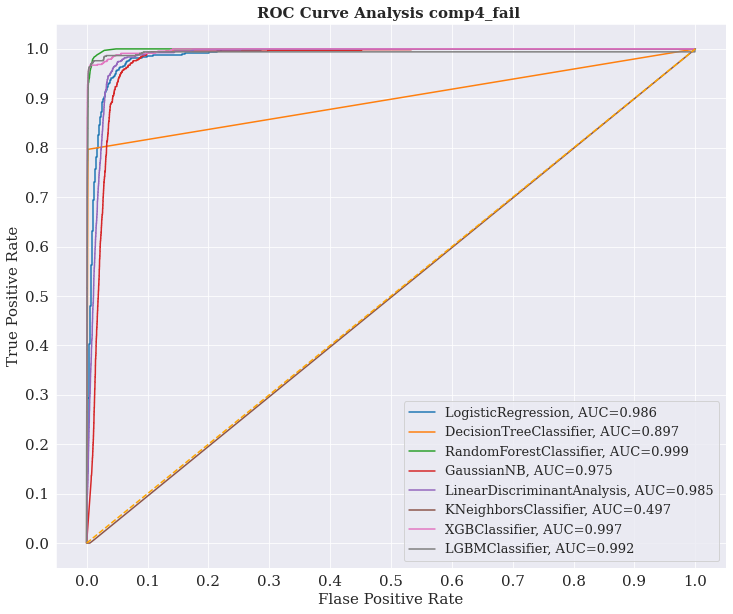

In [18]:
for comp in y.columns:
  fig = plt.figure(figsize=(12,10))

  for i in range(0,len(result_table.index)):
    if result_table.iloc[i]['compressor'] == comp:
        plt.plot(result_table.iloc[i]['fpr'], 
              result_table.iloc[i]['tpr'], 
              label=f"{result_table.index[i]}, AUC={result_table.iloc[i]['auc']:.3}")
      
  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("Flase Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title(f'ROC Curve Analysis {comp} ', fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()

#### Accuracy BoxPlot

The performance for the most common machine learning algorithms will be compared, first visually with a boxplot showing the accuracy and after with a table containing more metrics.

We discard the KNN and Decision Trees since they had the worst performance in the ROC curve.

In [17]:
models = []
models.append(('LOGR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('XGB', XGBClassifier(objective='binary:logistic',eval_metric='auc')))
models.append(('LGBMC', LGBMClassifier()))

Source : https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

Evaluating for component comp1_fail

LOGR: 0.989338 (0.000262) 11.278106212615967 seg
RFC: 0.997896 (0.000102) 244.69888186454773 seg
GNB: 0.963150 (0.001345) 1.5834696292877197 seg
LDA: 0.974427 (0.000122) 6.047877073287964 seg
XGB: 0.999245 (0.000059) 98.03239703178406 seg
LGBMC: 0.998250 (0.000070) 6.544692039489746 seg



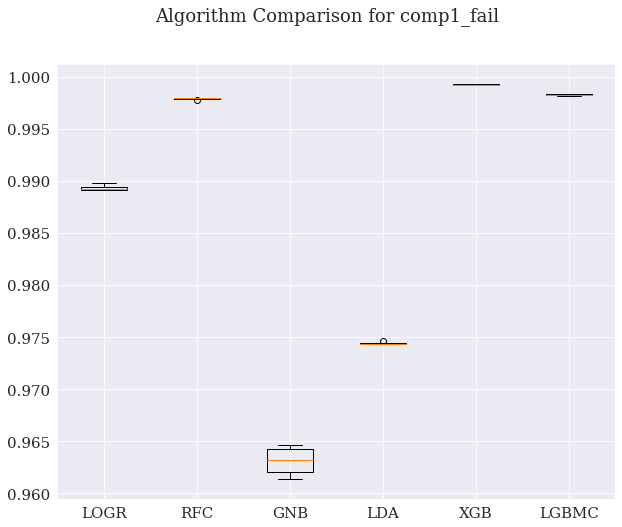


Evaluating for component comp2_fail

LOGR: 0.984876 (0.000361) 9.96619200706482 seg
RFC: 0.997869 (0.000277) 227.6114480495453 seg
GNB: 0.961987 (0.001056) 1.4323289394378662 seg
LDA: 0.971795 (0.000798) 5.546538829803467 seg
XGB: 0.999015 (0.000033) 90.02405595779419 seg
LGBMC: 0.998391 (0.000130) 6.137513875961304 seg



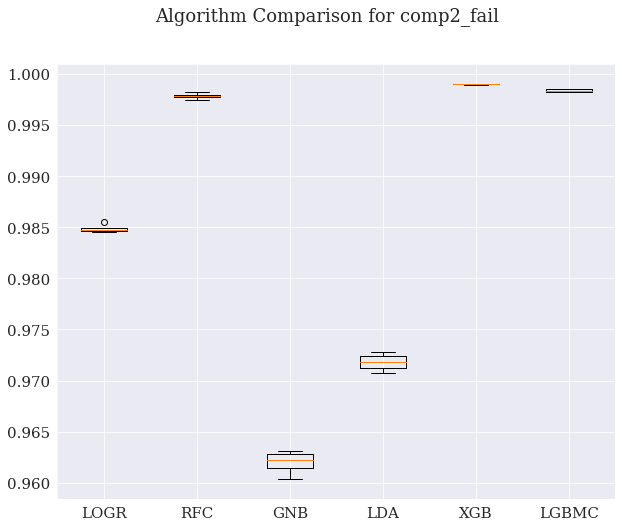


Evaluating for component comp3_fail

LOGR: 0.992371 (0.000175) 9.259103059768677 seg
RFC: 0.999664 (0.000045) 171.47868013381958 seg
GNB: 0.983233 (0.000432) 1.4457619190216064 seg
LDA: 0.975323 (0.000158) 5.521620035171509 seg
XGB: 0.999866 (0.000039) 71.19939684867859 seg
LGBMC: 0.998318 (0.002224) 5.340919017791748 seg



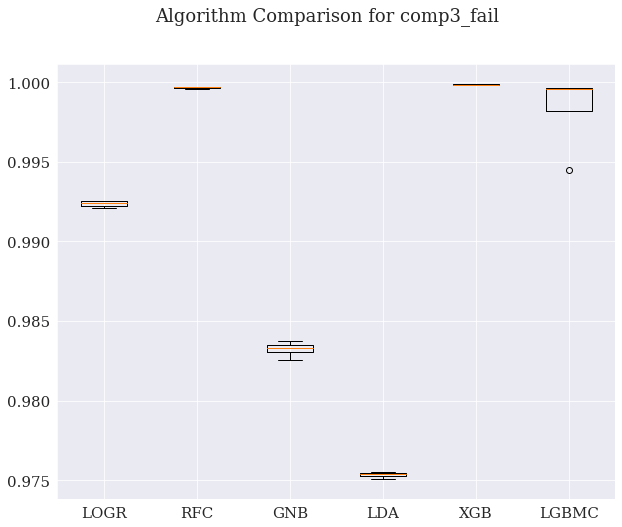


Evaluating for component comp4_fail

LOGR: 0.990353 (0.000064) 9.24547815322876 seg
RFC: 0.999351 (0.000101) 189.8003270626068 seg
GNB: 0.965429 (0.001008) 1.5349318981170654 seg
LDA: 0.977553 (0.000402) 5.875673055648804 seg
XGB: 0.999691 (0.000081) 86.51841998100281 seg
LGBMC: 0.999345 (0.000061) 6.594231128692627 seg



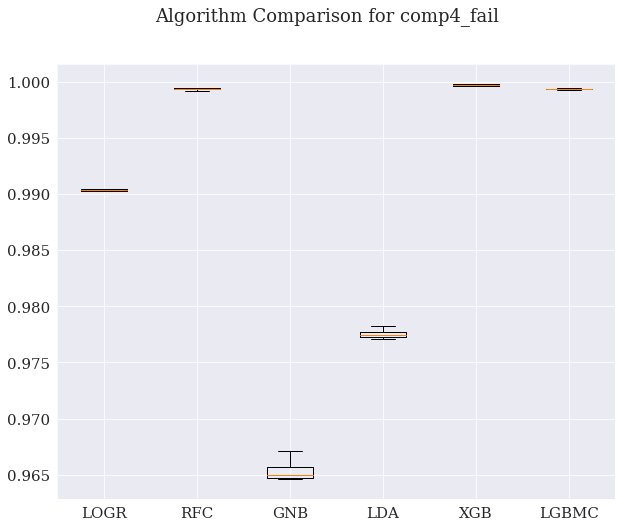

In [20]:
%timeit

# prepare configuration for cross validation test harness
seed = 7
# number of splits
num_splits = 4

for comp in y.columns:

  # evaluate each model in turn
  
  results = []
  names = []
  scoring = 'accuracy'
  print('Evaluating for component ' + comp)
  print()

  for name, model in models:
    # set start time
    start_time = time()

    kfold = model_selection.KFold(n_splits=num_splits, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y[comp], cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)



    # set end time: execution time
    exec_time = time() - start_time

    msg = "%s: %f (%f) %s seg" % (name, cv_results.mean(), cv_results.std() , exec_time)
    print(msg)

  print()
  # boxplot algorithm comparison
  fig = plt.figure()
  fig.set_size_inches(10,8)
  fig.suptitle(f'Algorithm Comparison for {comp}')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names)
  plt.show()

  print()

#### Comparison table between models

Source: https://gist.github.com/rsalaza4/638cbd28d4eef64ae7815186572e62f2

In [18]:
for comp in y:

  models_scores_table = pd.DataFrame()

  for name, model in models:

    model_score = models_evaluation(X, y[comp], 5, name, model)
    models_scores_table = pd.concat([models_scores_table, model_score], axis=1)
  
  print(f'Table results for {comp} :')
  # Add 'Best Score' column

  models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

  display(models_scores_table)
  print()

Table results for comp1_fail :


,LOGR,RFC,GNB,LDA,XGB,LGBMC,Best Score
Accuracy,0.989293,0.867903,0.961973,0.974441,0.995590,0.993778,XGB
Precision,0.411068,0.516271,0.171752,0.234842,0.796654,0.697719,XGB
Recall,0.093489,0.767947,0.704174,0.658097,0.771285,0.719866,XGB
F1 Score,0.150420,0.461285,0.276054,0.346135,0.783095,0.706771,XGB
AUC Score,0.546042,0.818444,0.834412,0.817911,0.884603,0.858245,XGB
Exec Time,15.541093,343.835433,2.184362,8.051194,115.130470,7.826536,RFC
AUC/time,0.035135,0.002380,0.381993,0.101589,0.007683,0.109658,GNB



Table results for comp2_fail :


,LOGR,RFC,GNB,LDA,XGB,LGBMC,Best Score
Accuracy,0.984653,0.819574,0.960841,0.971736,0.994001,0.994094,LGBMC
Precision,0.394078,0.525239,0.221599,0.289242,0.784682,0.789426,LGBMC
Recall,0.166371,0.866855,0.701187,0.684451,0.814676,0.802075,RFC
F1 Score,0.232342,0.517238,0.336654,0.406625,0.793794,0.792801,XGB
AUC Score,0.581384,0.842875,0.832877,0.830155,0.905625,0.899463,XGB
Exec Time,12.202208,316.570163,2.387064,8.366230,118.706184,8.343807,RFC
AUC/time,0.047646,0.002663,0.348913,0.099227,0.007629,0.107800,GNB



Table results for comp3_fail :


,LOGR,RFC,GNB,LDA,XGB,LGBMC,Best Score
Accuracy,0.992059,0.839314,0.982852,0.975168,0.997574,0.823421,XGB
Precision,0.352764,0.728495,0.293434,0.194597,0.836583,0.567376,XGB
Recall,0.115553,0.816198,0.900397,0.793520,0.855953,0.751403,GNB
F1 Score,0.164405,0.669261,0.439138,0.312403,0.834426,0.560856,XGB
AUC Score,0.556938,0.827838,0.941919,0.884993,0.927270,0.787669,GNB
Exec Time,12.009345,230.851825,2.077039,7.690636,90.375977,7.681528,RFC
AUC/time,0.046375,0.003586,0.453491,0.115074,0.010260,0.102541,GNB



Table results for comp4_fail :


,LOGR,RFC,GNB,LDA,XGB,LGBMC,Best Score
Accuracy,0.990319,0.997900,0.964925,0.977457,0.998229,0.997378,XGB
Precision,0.515165,0.883000,0.190184,0.263966,0.887872,0.856986,XGB
Recall,0.237782,0.911002,0.793172,0.732680,0.943015,0.893767,XGB
F1 Score,0.319730,0.895494,0.306642,0.388055,0.913453,0.870336,XGB
AUC Score,0.617758,0.954879,0.879895,0.856275,0.970894,0.946083,XGB
Exec Time,12.312939,262.258548,2.359103,8.285940,117.013164,9.389118,RFC
AUC/time,0.050171,0.003641,0.372978,0.103341,0.008297,0.100764,GNB


# Conclusion

We see that the models with best performance are the tree ones. Specially in the ROC curves we notice the models with bigger area under the curve and therefore higher AUC are.

- Random Forest
- **LGBMC**
- **XGB**

If we compare metrics/ execution time, we have two clear winners, whose models will be created in the following section. XGB is the one which has most of the times the best performance, and we have LGBMC with very good performance and shorter time.